SHAP를 이용해 CO2RR 공정 데이터를 MLP로 도출한 결과를 분석하자

step1. 라이브러리 정리

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


step2. 엑셀 파일 불러오기

In [2]:
# 엑셀 데이터 로드 
filepath = r"C:\Users\kepco201\Desktop\SHAP_Project\25.01.14_CO2RR_GSA.xlsx"
excel_file = pd.ExcelFile(filepath) 
df_in  = pd.read_excel(excel_file, sheet_name='Input')
df_out = pd.read_excel(excel_file, sheet_name='Output')

step3.Outlier 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [3]:
# 이상치(Outlier) 제거 (IQR 방식) ---
print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers



# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("이상치 제거 완료 ")


# 이제 'df_in_final'과 'df_out_final'을 사용하자





이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
이상치 제거 완료 


step4. outlier 제거 후 X와 y 정의

In [4]:
# 입력 변수(X) 선택
# 모델이 '총 필요 에너지'를 예측하는 데 사용할 정보(컬럼)들을 선택
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values



predicting = "Required energy_total (MJ/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1개




print(X)
print("====================")
print(y)


[[1.97379048e+03 9.73836465e-01 3.72471012e-02 ... 2.89292283e+02
  3.14514194e+00 1.49940024e-01]
 [1.95631747e+03 9.63060776e-01 5.54118353e-02 ... 2.92153805e+02
  3.24190324e+00 2.49900040e-01]
 [1.93884446e+03 9.52285086e-01 7.35765694e-02 ... 2.95015327e+02
  3.33866453e+00 3.49860056e-01]
 ...
 [1.61155538e+02 5.37714914e-01 5.36423431e-01 ... 3.38318006e+02
  4.66133547e+00 1.65013994e+00]
 [1.43682527e+02 5.26939224e-01 5.54588165e-01 ... 3.41179528e+02
  4.75809676e+00 1.75009996e+00]
 [1.26209516e+02 5.16163535e-01 5.72752899e-01 ... 3.44041050e+02
  4.85485806e+00 1.85005998e+00]]
[[137.83276055]
 [ 97.65612097]
 [ 77.61576681]
 ...
 [ 47.34602399]
 [ 50.01962389]
 [ 53.6021701 ]]


step5. train_set, valadation_set, test_set 만들기 (64:16:20) 

In [5]:
# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨



print(X_val)
print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

[[6.39764094e+02 8.75483806e-01 2.88958417e-01 ... 3.31531387e+02
  3.22830868e+00 3.92243103e-01]
 [1.92303079e+02 6.42141144e-01 1.31609356e-01 ... 3.46927896e+02
  3.07636945e+00 1.13674530e+00]
 [1.80057977e+03 5.59070372e-01 2.64424230e-01 ... 3.34950020e+02
  3.93042783e+00 1.81567373e+00]
 ...
 [1.23612555e+03 6.04132347e-01 1.88462615e-01 ... 2.99953352e+02
  4.33506597e+00 1.76129548e+00]
 [1.70637745e+03 6.59774090e-01 1.61333467e-01 ... 3.05549780e+02
  3.23470612e+00 1.97241104e+00]
 [1.03100760e+03 8.20625750e-01 1.96483407e-01 ... 3.39052379e+02
  3.72091164e+00 1.93482607e+00]]
전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)


step6. 데이터 전처리(0.1~0.9로 scaling)

In [6]:
# 중요: 훈련 데이터(X_train, y_train)의 최소/최대값을 기준으로 스케일러를 학습(fit)하고,
# 이 기준으로 모든 데이터셋(train, val, test)을 동일하게 변환합니다.
# 이렇게 해야 테스트 과정에서 미래 정보(테스트셋의 최소/최대값)가 모델에 유출되는 것을 막을 수 있다.
# validation dataset이나 test data로 스케일링을 할 시 데이터 누수 발생 가능

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_scaled = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
Y_train_scaled= scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

Y_val_scaled = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
Y_test_scaled = scaler_y.transform(y_test)



# X_train_norm 은 [[x0~x7], [x0~x7],....,[x0~x7]] 에서 각 x0~x7은 각 열마다 각각 범위가 0~1로 범위가 변환됨
# 이 변환된 정도를 X_val_norm 과 X_test_norm도 적용받음

print("\n--- 데이터 분할 및 전처리 최종 결과 ---")
print(f"훈련 데이터 형태: X({X_train_scaled.shape}), Y({Y_train_scaled.shape})")
print(f"검증 데이터 형태: X({X_val_scaled.shape}), Y({Y_val_scaled.shape})")
print(f"테스트 데이터 형태: X({X_test_scaled.shape}), Y({Y_test_scaled.shape})")




print("\n\n 스케일링된 훈련 데이터(X_train_scaled) 샘플:")

feature_names = [
    "Current density (mA/cm2)", "Faradaic efficiency (%)", "CO coversion",
    "Voltage (V)", "Electricity cost ($/kWh)", "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", "Crossover rate"
]

 

print(pd.DataFrame(X_train_scaled, columns=feature_names).head())


--- 데이터 분할 및 전처리 최종 결과 ---
훈련 데이터 형태: X((1521, 8)), Y((1521, 1))
검증 데이터 형태: X((381, 8)), Y((381, 1))
테스트 데이터 형태: X((476, 8)), Y((476, 1))


 스케일링된 훈련 데이터(X_train_scaled) 샘플:
   Current density (mA/cm2)  Faradaic efficiency (%)  CO coversion  \
0                  0.602348                 0.823169      0.516976   
1                  0.800891                 0.874710      0.772435   
2                  0.886073                 0.797559      0.553894   
3                  0.627611                 0.848459      0.150762   
4                  0.220810                 0.139056      0.843634   

   Voltage (V)  Electricity cost ($/kWh)  Membrain cost ($/m2)  \
0     0.807803                  0.575070              0.115366   
1     0.869588                  0.791797              0.104802   
2     0.180352                  0.547219              0.864146   
3     0.773870                  0.273509              0.866066   
4     0.540176                  0.612525              0.544018   

   Catp

step7. MLP 구조 설계 및 여러 신경망 층 구조에 대한 GridSearchCV 진행을 통해 최적 구조 찾기

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor  # scikeras 권장
from sklearn.model_selection import GridSearchCV






# 1. 모델 생성 함수 정의 / units1 = hidden layer 1층 / units2 = hidden layer 2층
def create_ann_model(units1=32, units2=16, activation='relu'):     
    model = Sequential([
        Input(shape=(8,)),             # 입력 특성 8개
        Dense(units1, activation=activation),  # hidden layer (units1)개
        Dense(units2, activation=activation),  # 입력 특성 8개 (units2)개
        Dense(1, activation='linear')
    ])
    
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',   # loss function = MSE -- 이것에 따라 학습의 방향이 결정됨
        metrics=['mean_absolute_error']  # 학습에 영향은 주지 않지만 그냥 평가지표 MAE
    )
    return model  


# 2. 래퍼 정의 (scikeras)     
regressor = KerasRegressor(    # Keras로 만든 딥러닝 모델을 Scikit-learn의 회귀(Regressor) 모델처럼 보이게 포장 --- scikit-learn의 최적의 units 수 등을 찾는 gridsearchCV 같은 기능을 쓰기 가능
    model=create_ann_model,    
    verbose=0                  # verbose = 0 --- 모델 훈련과정 출력 X // 1 -- 출력  //  2 -- epoch 끝날때마다 출력
)



# 3. 모델 생성 및 구조 확인
# Required energy_total 예측 모델
#ann_model = create_ann_model()

# 모델의 구조를 요약하여 출력합니다.
#print("--- 'Required energy_total' 예측 모델 구조 ---")
#ann_model.summary()







# 4. GridSearchCV를 통해 검사할 놈들 결정 .. 나중에 GridSearchCV.fit()을 통해 학습 예정
grid = GridSearchCV(
    estimator = KerasRegressor( model=create_ann_model,verbose=0),   # Keras로 만든 딥러닝 모델을 Scikit-learn의 회귀(Regressor) 모델처럼 보이게 포장 --- scikit-learn의 최적의 units 수 등을 찾는 gridsearchCV 같은 기능을 쓰기 가능    
                                                                     # verbose = 0 --- 모델 훈련과정 출력 X // 1 -- 출력  //  2 -- epoch 끝날때마다 출력
    param_grid= {
        'model__units1': [16, 32],                    # hidden layer 1층 뉴런수 
        'model__units2': [8, 16],                     # hidden layer 2층 뉴런수
        'model__activation': ['relu', 'tanh'],        # 활성화함수
        'batch_size': [32],                           # 배치 사이즈
        'epochs': [100],                              # 학습 epoch 수  --- 총 학습 수 = 2*2*2 = 8 이다.
    },
    cv=3,                              # cross validation 3번 (3 fold validation)  --- 총 학습 수 = 8*3 = 24
    scoring='neg_mean_squared_error',  # -MSE가 높을수록 좋다고 설정
    n_jobs=-1                          # 사용 가능한 CPU 코어 전부 사용하라는 의미
)



grid_result = grid.fit(X_train_scaled, Y_train_scaled)   # GridSearchCV.fit() 실행하기 -- 여러 모델 구조 비교 --- 여러 정보가 grid_result에 할당이 됨


# 6. 결과 출력
print("최적 하이퍼파라미터:", grid_result.best_params_)
print("최적 평균 검증 MSE:", -grid_result.best_score_)  # 아까 score = -MSE로 정의함




# 7. 최적 파라미터 추출 / best_params에 저장되어 있는 최적 정보들 활용
optimal_units1 = grid_result.best_params_['model__units1']                   # best_params[키] = 밸류값 출력
optimal_units2 = grid_result.best_params_['model__units2'] 
optimal_activation = grid_result.best_params_['model__activation']
optimal_batch_size = grid_result.best_params_['batch_size']






# GridSearchCV.fit() 을 실행했을 때 과정
cv_results = pd.DataFrame(grid_result.cv_results_)  # 결과표를 pandas dataframe으로 변환 --- 그러면 보기 편함

print("\n=== GridSearchCV 상세 결과 ===")   
print(cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)) # grid_result.cv_results_ 의 값 중 3개의 변수만 뽑아서 보기
# .sort_values =pandas.DataFrame을 특정 열의 값을 기준으로 재배치
#  mean_test_score을 기준으로 ascending=False: 내림차순 정렬 -- 성능이 가장 좋은 것이 위로 간다



# 9. 최적 모델 구조 보여주기
print(f"최적 모델 구조:8- {optimal_units1}-{optimal_units2}-1, activation: {optimal_activation}")




# 7. (선택) 결과 table을 보기 좋게 정리
# import pandas as pd
# cv_results = pd.DataFrame(grid_result.cv_results_)
# display(cv_results.sort_values('mean_test_score', ascending=False))


최적 하이퍼파라미터: {'batch_size': 32, 'epochs': 100, 'model__activation': 'relu', 'model__units1': 32, 'model__units2': 16}
최적 평균 검증 MSE: 0.00038579158890046845

=== GridSearchCV 상세 결과 ===
                                              params  mean_test_score  \
3  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000386   
1  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000390   
2  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000399   
0  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000564   
4  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001068   
6  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001416   
5  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001611   
7  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.002576   

   std_test_score  
3        0.000018  
1        0.000133  
2        0.000032  
0        0.000056  
4        0.000184  
6        0.000353  
5        0.000657  


모델 학습 및 plot

--- 모델 학습을 시작합니다 ---

--- 모델 학습 완료 ---

--- 테스트 데이터 이용 모델 성능 평가 ---
테스트 데이터 손실 (MSE): 0.0002
테스트 데이터 평균 절대 오차 (MAE): 0.0094
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
테스트 데이터 결정계수 (R²): 0.9881
최적의 epoch: 111
최소 val_loss: 0.00019


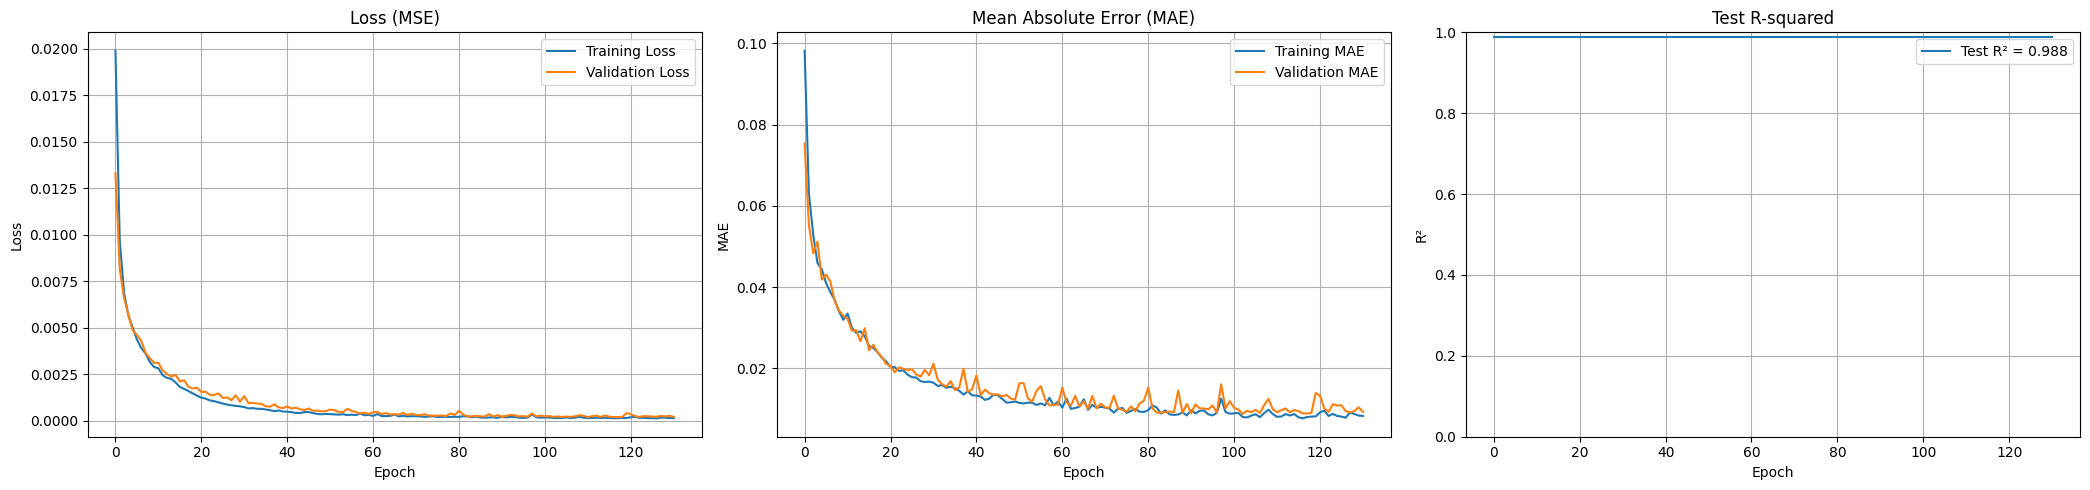

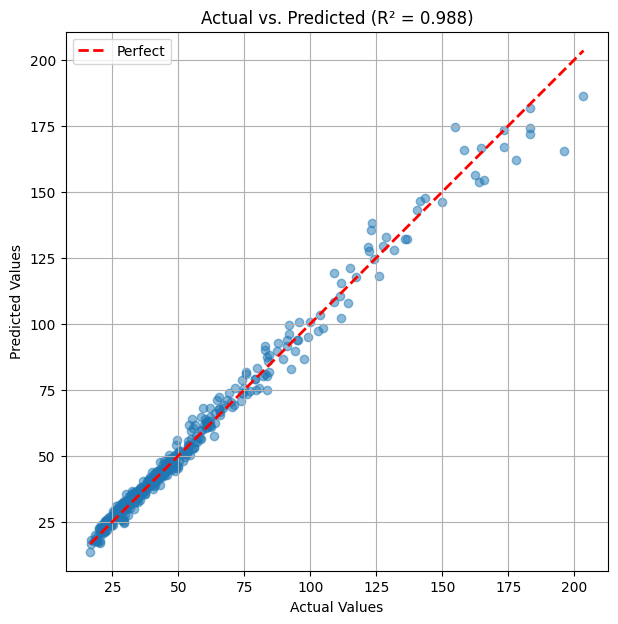

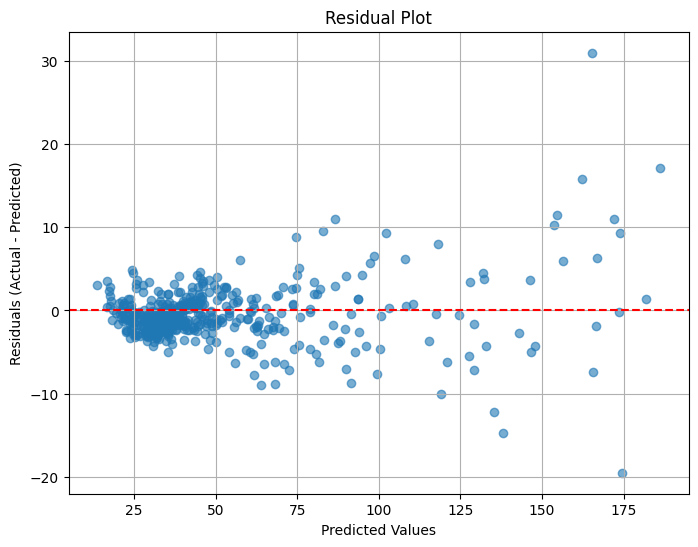


=== 최종 모델 성능 요약 ===
모델 구조: 8-32-16-1
활성화 함수: relu
최적 epoch: 111
테스트 R²: 0.9881
테스트 MAE: 0.0094


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping





def create_optimal_model():
    model = Sequential([
        Input(shape=(8,)),
        Dense(optimal_units1, activation=optimal_activation),
        Dense(optimal_units2, activation=optimal_activation),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

ann_model = create_optimal_model() # 100 epoch 기준 최적 모델 구조 생성




print("--- 모델 학습을 시작합니다 ---")  

early_stopping = EarlyStopping( # 최적 모델 학습 (Training)
    monitor='val_loss',         # 검증 손실 기준 = val_loss = validation set의 RMSE
    patience=20,                # 개선되지 않는 epoch 20회 동안 기다리기(8~20 추천)
    restore_best_weights=True   # 가장 좋은 가중치로 복원
)


history = ann_model.fit(
    X_train_scaled, 
    Y_train_scaled,
    epochs=1000, #충분히 큰 값으로 설정
    batch_size=optimal_batch_size, #  # GridSearchCV 결과 활용 --- 아까 32라고 정의
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stopping],  # callback 중 1개인 Early_stopping 이용/ overfitting 뜨기 전에 earlystopping 으로 끊기
    verbose=0 # 각 epoch마다 진행상황 표현
)
print("\n--- 모델 학습 완료 ---")






 





# 3. 모델 성능 평가 (Evaluation)
print("\n--- 테스트 데이터 이용 모델 성능 평가 ---")
test_loss, test_mae = ann_model.evaluate(X_test_scaled, Y_test_scaled, verbose=0) # evaluate 함수 이용 / verbose = 0 이라 평과과정 출력 X / model을 compile 할 떄 정의한 loss 와 metrics 출력
print(f"테스트 데이터 손실 (MSE): {test_loss:.4f}")
print(f"테스트 데이터 평균 절대 오차 (MAE): {test_mae:.4f}")




# 예측한 값 출력
Y_pred_scaled = ann_model.predict(X_test_scaled)   # predict(입력변수) 함수는 모델의 출력값(예측값) 출력
Y_pred = scaler_y.inverse_transform(Y_pred_scaled) # 역변환을 통해 Y_pred를 구함
Y_test_true = y_test          # 가독성을 위해...




# 상관계수 R^2 출력
r2 = r2_score(Y_test_true, Y_pred)   # r2_score 함수를 이용해 결정계수 R^2을 구함
print(f"테스트 데이터 결정계수 (R²): {r2:.4f}")  # r2를 소수점 뒤에 4자리까지만 출력


# best_epoch 출력 + 최소 val_loss 출력
best_epoch = np.argmin(history.history['val_loss']) + 1  # 가장 val_loss 가 낮았던 epoch 수를 찾기 // np.argmin 함수는 리스트에서 가장 작은 값의 인덱스(위치) 출력
print(f"최적의 epoch: {best_epoch}")                      # 위에 것을 이어 쓰자면 model.fit.history이다. 뒤의 .history를 통해 모든 훈련과정의 기록(log)를 출력 // 그 중 val_loss 만 뽑아서 보기 -- 그 중 가장 작은 값의 인덱스 출력 np.argmin
print(f"최소 val_loss: {history.history['val_loss'][best_epoch-1]:.5f}") # .history에서 np.argmin까지 하면 index 번호에 자동으로 +1을 해서 인간이 보기 편하도록 출력을 해줌 --- -1 해줘서 index 번호 넣어주기








# 5. 학습 과정 시각화 (Loss, MAE, R²)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))   # plt.subplots(1, 3) = 1행 3열로 전체 그래프 부분 나누기  // figsize는 전체 그래프 크기 // 전체 그래프 구간을 나눠서 각각 할당해서 그릴 때 subplot 이용

# ax1 = 첫번쨰 그림판 --  Loss 그래프 그리기
ax1.plot(history.history['loss'], label='Training Loss')   # 참고로 history = model.fit() 이라고 앞에서 정의를 해놓음 // 범례(legend)를 Training loss 라 이름지음
ax1.plot(history.history['val_loss'], label='Validation Loss')  # model.fit이 진행될때마다 loss 와 val_loss를 그리기
ax1.set_title('Loss (MSE)')  # set_title = 그래프 제목
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True) # .legend() --- 아까 label로 이름 붙여놓은 애들 표시 // .grid(True) -- 격자무늬 추가


# ax2 = MAE
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')   # 아까 model.compile 할 떄 MAE 미리 선언함
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')  # Keras는 자동으로 validation set의 키 값 앞에 접두사 val_을 붙여준다
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MAE'); ax2.legend(); ax2.grid(True)

# ax3 = R² 수기계산(별도 그래프)
ax3.plot([r2]*len(history.history['loss']), label=f'Test R² = {r2:.3f}') # r2를 총 epoch 수만큼 만듦 -- 그래프 직선형으로 그리려고
ax3.set_title('Test R-squared')
ax3.set_xlabel('Epoch'); ax3.set_ylabel('R²'); ax3.legend(); ax3.grid(True)
ax3.set_ylim(bottom=0, top=1)

plt.tight_layout() # layout 자동으로 깔끔하게 그래프 보여줌
plt.show()  # 화면에 그래프 출력









# 6. 실제값-예측값 산점도
plt.figure(figsize=(7,7))
plt.scatter(Y_test_true, Y_pred, alpha=0.5) # alpha는 투명도를 의미 .scatter()을 통해 산점도 그리기 . x 값은 실제값 y 값은 예측값

# y = x 기준선 그리기
plt.plot([Y_test_true.min(), Y_test_true.max()],  # 선의 시작과 끝점 x좌표 
         [Y_test_true.min(), Y_test_true.max()], 'r--', lw=2, label='Perfect') # 선의 시작과 끝점 y좌표 --- x좌표와 같으므로 y = x 그래프를 그린다  # lw = linewidth = 선 굵기
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted (R² = {r2:.3f})")
plt.legend(); plt.grid(True); plt.axis('equal') #plt.axis('equal')을 통해 y=x에 
plt.show()



# 7. 잔차 플롯 (residuals)
residuals = (Y_test_true.flatten() - Y_pred.flatten())   # residuals = 실제값 - 예측값
plt.figure(figsize=(8,6))    # 그래프 크기
plt.scatter(Y_pred, residuals, alpha=0.6)  # x축 값 = 예측값, y축 값 = (실제값- 예측값)
plt.axhline(0, color='red', linestyle='--') # axhline = 수평선(Axis Horizontal Line)**을 그리는 함수
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True) # 뒤에 격자 표시
plt.show()



# 모델 성능 요약 
print(f"\n=== 최종 모델 성능 요약 ===")
print(f"모델 구조: 8-{optimal_units1}-{optimal_units2}-1")
print(f"활성화 함수: {optimal_activation}")
print(f"최적 epoch: {best_epoch}")
print(f"테스트 R²: {r2:.4f}")
print(f"테스트 MAE: {test_mae:.4f}")

SHAP 이용 분석 시작

1. SHAP 분석을 위한 Explainer 생성

In [9]:
from sklearn.model_selection import train_test_split
import shap

# 1. SHAP Explainer가 사용할 배경 데이터(background data)를 준비합니다.
#    훈련 데이터셋(X_train_scaled)의 특성을 대표하도록 100개의 데이터를 요약(kmeans)합니다.
#    이는 계산 효율성을 위해 필수적인 과정입니다.
print("배경 데이터셋을 생성합니다. (시간이 조금 걸릴 수 있습니다)")
background_data = shap.kmeans(X_train_scaled, 100)
print("배경 데이터셋 생성 완료!")




# 2. MLP 모델(ann_model)을 해석할 KernelExplainer를 생성합니다.
#    - 첫 번째 인자: 모델의 예측 함수(ann_model.predict)를 전달합니다.
#    - 두 번째 인자: 위에서 만든 배경 데이터를 전달합니다.
print("SHAP KernelExplainer를 생성합니다...")
explainer = shap.KernelExplainer(ann_model.predict, background_data) 
print("Explainer 생성 완료!")

# 생성된 explainer 객체 확인
print("\nExplainer 객체 정보:")
print(explainer)


c:\Users\kepco201\Desktop\SHAP_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


배경 데이터셋을 생성합니다. (시간이 조금 걸릴 수 있습니다)
배경 데이터셋 생성 완료!
SHAP KernelExplainer를 생성합니다...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Explainer 생성 완료!

Explainer 객체 정보:


2. SHAP값 계산 ---- 시간 매우 오래 걸림!!!

In [10]:
# Step 8. SHAP 값 계산
# KernelExplainer는 계산에 시간이 많이 소요된다!! 

print("SHAP 값 계산을 시작합니다. (시간이 몇 분 정도 소요될 수 있습니다)")
# 테스트 데이터셋(X_test_scaled)에 대한 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X_test_scaled, silent = True)  # 학습과정 안보고 싶으면 여기다가 , silent = True 붙이기 // 학습과정 보고 싶으면 그냥 silent = True 지우기
print("SHAP 값 계산 완료!")

# 계산된 SHAP 값의 형태(shape) 확인
print(f"\n계산된 SHAP 값의 형태: {shap_values.shape}")


SHAP 값 계산을 시작합니다. (시간이 몇 분 정도 소요될 수 있습니다)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

Explanation 객체 만들기

In [11]:
# 앞에서 오랜시간동안 계산된 shap_values 변수 사용

print("SHAP Explanation 객체 생성")

# shap_values와 explainer.expected_value에서 [0]을 모두 제거합니다.
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_scaled,
    feature_names=feature_names
)
print("Explanation 객체 생성 완료!")


SHAP Explanation 객체 생성
Explanation 객체 생성 완료!


Graph 1. Summary Plot

--- 진단 완료! 원인을 파악하여 최종 코드를 실행합니다 ---
1. shap_values의 형태를 (476, 8, 1)에서 (476, 8)로 수정합니다...
   => 수정된 형태(Shape): (476, 8)

2. 수정된 데이터로 SHAP Explanation 객체를 생성합니다...
   => 객체 생성 완료.

3. 올바른 객체로 Summary Plot을 생성합니다. 이번에는 정상적으로 표시될 것입니다.


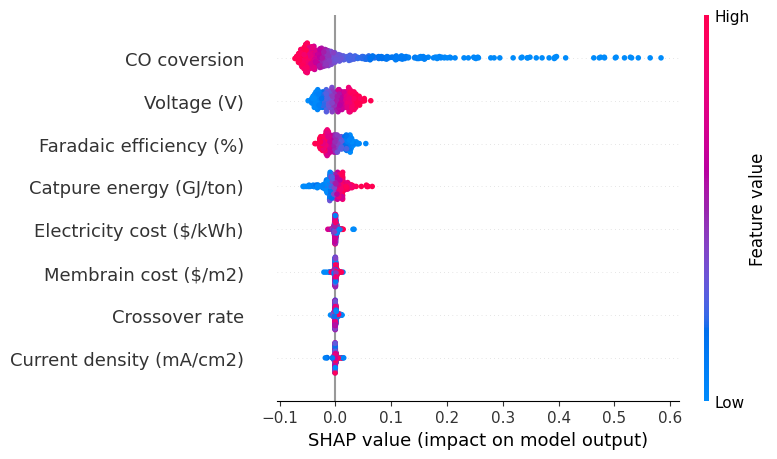

In [ ]:
# [최종 해결 코드]
# 원인: shap_values의 형태가 (476, 8, 1)인 3차원 배열이었음
# 해결: numpy.squeeze() 함수로 불필요한 차원을 제거하여 (476, 8) 형태로 만듦

import numpy as np
import shap
import matplotlib.pyplot as plt

print("--- 진단 완료! 원인을 파악하여 최종 코드를 실행합니다 ---")

# 1. 문제의 원인이었던 3차원 배열(476, 8, 1)을 2차원(476, 8)으로 변환합니다.
print("1. shap_values의 형태를 (476, 8, 1)에서 (476, 8)로 수정합니다...")
shap_values_corrected = np.squeeze(shap_values)
print(f"   => 수정된 형태(Shape): {shap_values_corrected.shape}")

# 2. 수정된 배열을 사용해 SHAP Explanation 객체를 다시 생성합니다.
print("\n2. 수정된 데이터로 SHAP Explanation 객체를 생성합니다...")
shap_explanation_corrected = shap.Explanation(
    values=shap_values_corrected,
    base_values=explainer.expected_value,
    data=X_test_scaled,
    feature_names=feature_names
)
print("   => 객체 생성 완료.")

# 3. 최종적으로 수정된 객체로 Summary Plot을 생성합니다.
print("\n3. 올바른 객체로 Summary Plot을 생성합니다. 이번에는 정상적으로 표시될 것입니다.")
shap.summary_plot(shap_explanation_corrected)
plt.show()


print(predicting)


Graph2. waterfall 그래프

SHAP Waterfall Plot
첫 번째 샘플(인덱스 0)에 대한 분석


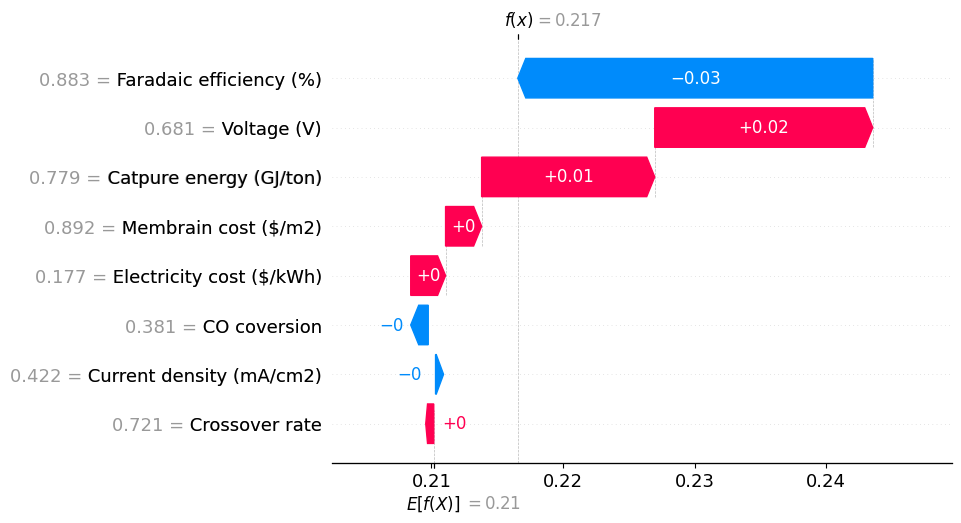

In [ ]:
# Step 9-2. Waterfall Plot으로 특정 데이터 예측 과정 분석하기
import shap
import matplotlib.pyplot as plt

print("SHAP Waterfall Plot")
print("첫 번째 샘플(인덱스 0)에 대한 분석")  #[0]을 바꿔가면서 보기 

# shap_explanation_corrected 객체에서 첫 번째 샘플을 선택하여 waterfall plot을 그립니다.
# 이 한 줄만으로도 복잡한 그래프가 그려집니다.
shap.plots.waterfall(shap_explanation_corrected[0])   #[0]을 바꿔가면서 보기


plt.show()
print(predicting)


Graph3. Dependence Plot

--- 오타(ValueError) 및 변수 부재(NameError) 문제를 모두 해결합니다 ---
1. 'shap_explanation_corrected' 변수를 다시 생성합니다...
   => 변수 생성 완료.

2. 이제 정상적으로 Dependence Plot을 생성합니다...


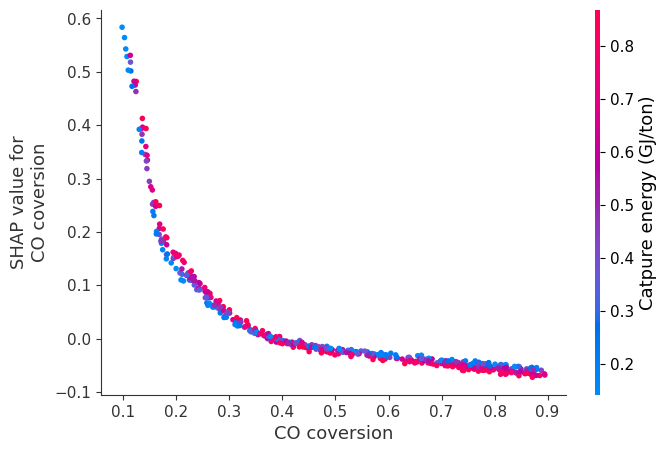

In [ ]:
# [최종 해결 코드] NameError와 ValueError를 모두 해결한 버전

import numpy as np
import shap
import matplotlib.pyplot as plt

print("--- 오타(ValueError) 및 변수 부재(NameError) 문제를 모두 해결합니다 ---")

# 1. 'shap_explanation_corrected' 변수를 다시 만듭니다.
#    (이미 계산된 shap_values 변수는 그대로 사용합니다)
print("1. 'shap_explanation_corrected' 변수를 다시 생성합니다...")
shap_values_corrected = np.squeeze(shap_values)
shap_explanation_corrected = shap.Explanation(
    values=shap_values_corrected,
    base_values=explainer.expected_value,
    data=X_test_scaled,
    feature_names=feature_names
)
print("   => 변수 생성 완료.")

# 2. 오타를 수정한 이름("CO coversion")으로 Dependence Plot을 그립니다.
print("\n2. 이제 정상적으로 Dependence Plot을 생성합니다...")
shap.dependence_plot(
    "CO coversion",  # <--- 'conversion'이 아니라 'coversion'으로 오타를 맞춰줍니다.
    shap_explanation_corrected.values,
    X_test_scaled,
    feature_names=feature_names,
    interaction_index="auto"
)
plt.show()
print(predicting)


Graph. Bar Plot (변수 중요도 막대그래프)

--- Bar Plot: 전체 변수 중요도 순위 ---


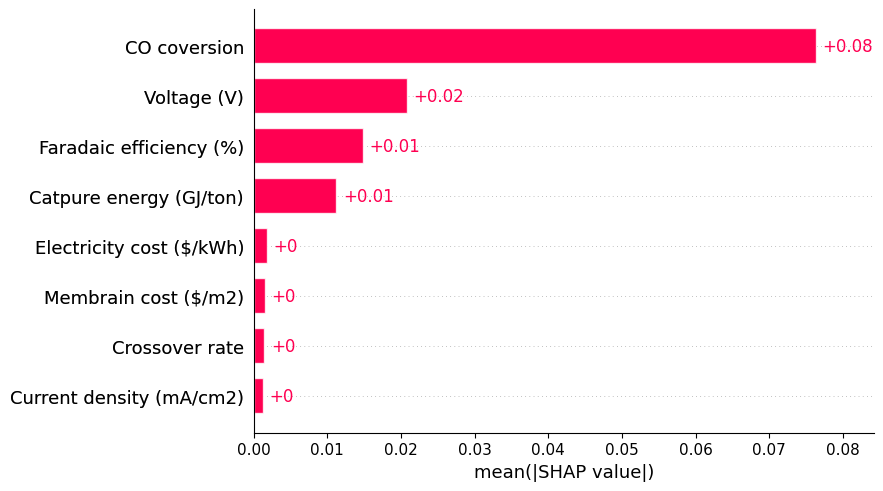

In [ ]:
# [코드 2] Bar Plot 생성

print("--- Bar Plot: 전체 변수 중요도 순위 ---")

# shap_explanation_corrected 객체를 넣으면 바로 그려집니다.
shap.plots.bar(shap_explanation_corrected)

# 만약 위 코드가 오류가 발생하면, 이전 버전의 함수를 사용해보세요.
# shap.summary_plot(shap_explanation_corrected, plot_type="bar")

plt.show()
print(predicting)

Graph. Force Plot 개별 예측 시각화

In [ ]:
# [코드 3] Force Plot 생성

# 3-1. 첫 번째 데이터 샘플(인덱스 0)에 대한 Force Plot
print("--- Force Plot: 첫 번째 샘플(인덱스 0) ---")
shap.plots.force(
    shap_explanation_corrected.base_values[0],
    shap_explanation_corrected.values[0],
    shap_explanation_corrected.data[0],
    feature_names=feature_names
)

# 3-2. (매우 유용) 전체 테스트 데이터에 대한 **상호작용형(Interactive) Force Plot**
# 이 코드를 실행하면 마우스 휠, 드롭다운 메뉴로 모든 샘플을 탐색할 수 있는 멋진 그래프가 나옵니다.
print("\n--- Interactive Force Plot: 모든 테스트 샘플 ---")
shap.initjs() # Javascript 시각화 라이브러리 로딩
shap.force_plot(
    shap_explanation_corrected.base_values,
    shap_explanation_corrected.values,
    shap_explanation_corrected.data,
    feature_names=feature_names
)

print(predicting)

--- Force Plot: 첫 번째 샘플(인덱스 0) ---

--- Interactive Force Plot: 모든 테스트 샘플 ---
